# Vanilla RNN mit den neu aufbereiteten Daten im Zuge der Thesis
Hierbei wurde ein Vanilla-RNN Modell trainiert mit den neu aufbereiteten Daten im Zuge dieser Thesis. Die Aufteilung in Trainings- und Testdaten ist hierbei im Dokument enthalten, da kein Shuffle enthalten ist. Man hätte diesen Prozess auslagern können, bedingt durch Google Colab war es jedoch einfacher den Prozess in den einzelnen Dokumenten zu behalten.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 98 kB 3.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FILE_NAME = "data_without_weather.csv"
FS_ROOT_PATH = '/content/drive/MyDrive/sensalytics/Rohdaten/'
CSV_PATH = FS_ROOT_PATH + FILE_NAME

## Data-Import:
Die Daten wurden hier bereits im Aufbereitungsprozess angepasst.

In [ ]:
dataset = pd.read_csv(filepath_or_buffer=CSV_PATH, index_col='Date_Time')
display(dataset.head(5))

,Visitor In,Visitor Out,Ø Occupancy,POS served,Ø Total Occupancy (Payer),Month,Weekday,Weekend,Hour
Date_Time,,,,,,,,,
2021-08-12 06:56:00,1,1,0,0,0,8,3,0,6
2021-08-12 06:58:00,0,1,0,2,0,8,3,0,6
2021-08-12 06:59:00,1,1,0,0,0,8,3,0,6
2021-08-12 07:00:00,2,0,1,0,0,8,3,0,7
2021-08-12 07:01:00,3,0,4,0,0,8,3,0,7


Hier wird die Label-Spalte vom Dataset getrennt.

In [ ]:
y = dataset.pop('Ø Total Occupancy (Payer)')
display(y.head(5))

Date_Time
2021-08-12 06:56:00    0
2021-08-12 06:58:00    0
2021-08-12 06:59:00    0
2021-08-12 07:00:00    0
2021-08-12 07:01:00    0
Name: Ø Total Occupancy (Payer), dtype: int64

## Many-To-One Modell (Ohne Wetterdaten):

Hier wird der Dataset in Trainings- und Testdaten eingeteilt. Dabei ist wichtig das Flag *shuffle=False* zu setzen, damit die Daten nicht gemischt werden. Danach werden die Daten mit Hilfe des **StandardScaler()** oder des **MinMaxScaler()** scaliert. Das verbessert das Training, da sich der Wertebereich der Features nicht so groß unterscheidet.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(dataset, y, test_size=0.2, random_state=0, shuffle=False)

input_scaler = MinMaxScaler()

input_scaler.fit(train_x, train_y)

train_x = input_scaler.transform(train_x)
test_x = input_scaler.transform(test_x)

Die Eingabe für jede RNN-Schicht muss dreidimensional sein. <br>
Die drei Dimensionen dieser Eingabe sind:

- **Samples:** Eine Sequenz ist eine Probe. Eine Batch besteht aus einer oder mehreren Proben.
- **Time Steps:** Ein Zeitschritt ist ein Beobachtungspunkt in der Stichprobe.
- **Features.** Ein Merkmal ist eine Beobachtung pro Zeitschritt.

---

Im *Many-To-One*-Ansatz werden hier die Daten mit dem Sliding-Window verfahren angepasst. Hierbei werden die letzten **n** Timestamps genommen um die nächsten **m** Timestamps vorherzusagen. Mit der Funktion *to_supervised()* werden die Tranings- und Testdaten deshalb angepasst. 

In [ ]:
N_INPUT = 180
M_OUTPUT = 10
FEATURES = dataset.shape[1]
EPOCHS = 100
BATCH_SIZE = 64

In [ ]:
def to_supervised(data, label, n_input, output_ix):
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(label)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		ix_output = ix_end + output_ix
		# ensure we have enough data for this instance
		if ix_output < len(label):
			X.append(data[ix_start:ix_end])
			y.append(label[ix_end:ix_output])
		# move along one time step
		ix_start += 1
	return np.array(X), np.array(y)

In [ ]:
train_x, train_y = to_supervised(train_x, train_y.values, N_INPUT, M_OUTPUT)
test_x, test_y = to_supervised(test_x, test_y.values, N_INPUT, M_OUTPUT)
print("train_x Shape:", train_x.shape)
print("train_y Shape:", train_y.shape)
print("test_x Shape:", test_x.shape)
print("test_y Shape:", test_y.shape)

train_x Shape: (67502, 180, 8)
train_y Shape: (67502, 10)
test_x Shape: (16733, 180, 8)
test_y Shape: (16733, 10)


Einfaches RNN-Modell um die Architektur zu testen und Hyperparameter händisch verändern zu können.

In [ ]:
# SimpleRNN Many-To-One Model
model_1 = Sequential()
model_1.add(SimpleRNN(64, input_shape=(N_INPUT, FEATURES)))
model_1.add(Dense(32))
model_1.add(Dense(M_OUTPUT))

model_1.compile(loss='mse', optimizer='Adam', metrics=['mae', 'mse'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4672      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 7,082
Trainable params: 7,082
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model_1.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2, callbacks=[early_stop])

Epoch 1/100
1055/1055 - 34s - loss: 18.9163 - mae: 3.2524 - mse: 18.9163 - val_loss: 12.3487 - val_mae: 2.7358 - val_mse: 12.3487 - 34s/epoch - 33ms/step
Epoch 2/100
1055/1055 - 34s - loss: 12.5853 - mae: 2.7197 - mse: 12.5853 - val_loss: 11.5260 - val_mae: 2.5858 - val_mse: 11.5260 - 34s/epoch - 32ms/step
Epoch 3/100
1055/1055 - 33s - loss: 12.1767 - mae: 2.6755 - mse: 12.1767 - val_loss: 11.4163 - val_mae: 2.6122 - val_mse: 11.4163 - 33s/epoch - 32ms/step
Epoch 4/100
1055/1055 - 34s - loss: 11.8001 - mae: 2.6293 - mse: 11.8001 - val_loss: 11.1141 - val_mae: 2.5445 - val_mse: 11.1141 - 34s/epoch - 32ms/step
Epoch 5/100
1055/1055 - 33s - loss: 11.4794 - mae: 2.5945 - mse: 11.4794 - val_loss: 10.8573 - val_mae: 2.5052 - val_mse: 10.8573 - 33s/epoch - 32ms/step
Epoch 6/100
1055/1055 - 34s - loss: 11.2371 - mae: 2.5654 - mse: 11.2371 - val_loss: 10.8713 - val_mae: 2.5306 - val_mse: 10.8713 - 34s/epoch - 32ms/step
Epoch 7/100
1055/1055 - 33s - loss: 11.3131 - mae: 2.5750 - mse: 11.3131 - v

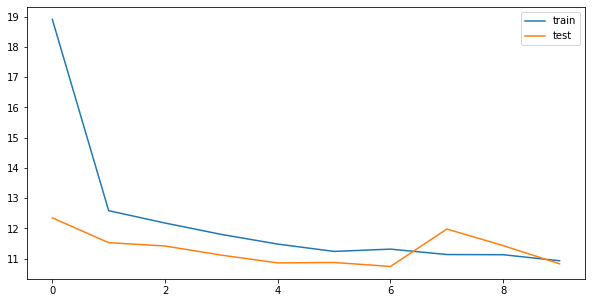

In [ ]:
# plot history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
loss, mae, mse = model_1.evaluate(test_x, test_y, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

523/523 - 4s - loss: 10.8264 - mae: 2.5169 - mse: 10.8264 - 4s/epoch - 8ms/step
Testing set Mean Abs Error:  2.52 MPG


In [ ]:
y_pred1 = model_1.predict(test_x)
y_pred1 = y_pred1.clip(min=0) # Negative Werte entfernen

In [ ]:
def calculate_metrics(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  rmsle = mean_squared_log_error(y_true, y_pred, squared=False)
  mae = mean_absolute_error(y_true, y_pred)
  med = median_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  
  return {'MSE': mse, 'RMSE': rmse, 'RMSLE': rmsle, 'MAE':mae, 'MED':med, 'R2':r2}

def evaluate_model(y_true, y_pred):
  df_scores = pd.DataFrame(columns=['MSE', 'RMSE', 'RMSLE', 'MAE', 'MED', 'R2'])

  # Berechnung der Metrics über die einzelnen Vorhersagen
  for i in range(y_true.shape[1]):
    score = pd.Series(calculate_metrics(y_true[:, i], y_pred[:, i]), name='min' + str(i+1) + ':')
    df_scores = df_scores.append(score)
  
  # Berechnugn der Metrics über alle Vorhersagen
  scores_total = pd.Series(calculate_metrics(y_true, y_pred), name='total:')
  df_scores= df_scores.append(scores_total)

  return df_scores

In [ ]:
df_scores = evaluate_model(test_y, y_pred1)
display(df_scores)

,MSE,RMSE,RMSLE,MAE,MED,R2
min1:,9.851100,3.138646,0.414130,2.402722,1.878953,0.734003
min2:,10.220549,3.196959,0.420475,2.447391,1.914055,0.724059
min3:,10.548179,3.247796,0.430818,2.490505,1.962683,0.715249
min4:,10.776510,3.282759,0.430908,2.513199,1.974693,0.709113
min5:,10.968998,3.311948,0.433258,2.531601,1.978716,0.703944
min6:,11.038144,3.322370,0.431797,2.536640,1.991666,0.702104
min7:,11.133420,3.336678,0.432922,2.548752,2.000330,0.699566
min8:,11.208047,3.347842,0.436595,2.560174,2.004269,0.697589
min9:,11.239043,3.352468,0.440578,2.565997,2.015114,0.696791
min10:,11.274362,3.357732,0.435967,2.560021,2.008947,0.695875


In [ ]:
np.std(test_y)

6.087091183799563

In [ ]:
def plot_all_predictions(y_pred, y_true):
  # Flatten of the predictions, and get the every 10th
  prediction = y_pred.flatten()[0::10]
  true = y_true.flatten()[0::10]

  plt.figure(figsize=(25,8))
  plt.title("Vergleich der Vorhersagen:")
  plt.plot(true, color='orange', linestyle='-', label='True')
  plt.plot(prediction, color='green', linestyle='--', label='Pred')
  plt.xlabel('Minuten')
  plt.ylabel('Personen im Kassenbereich')
  plt.legend()
  plt.grid()
  plt.show()

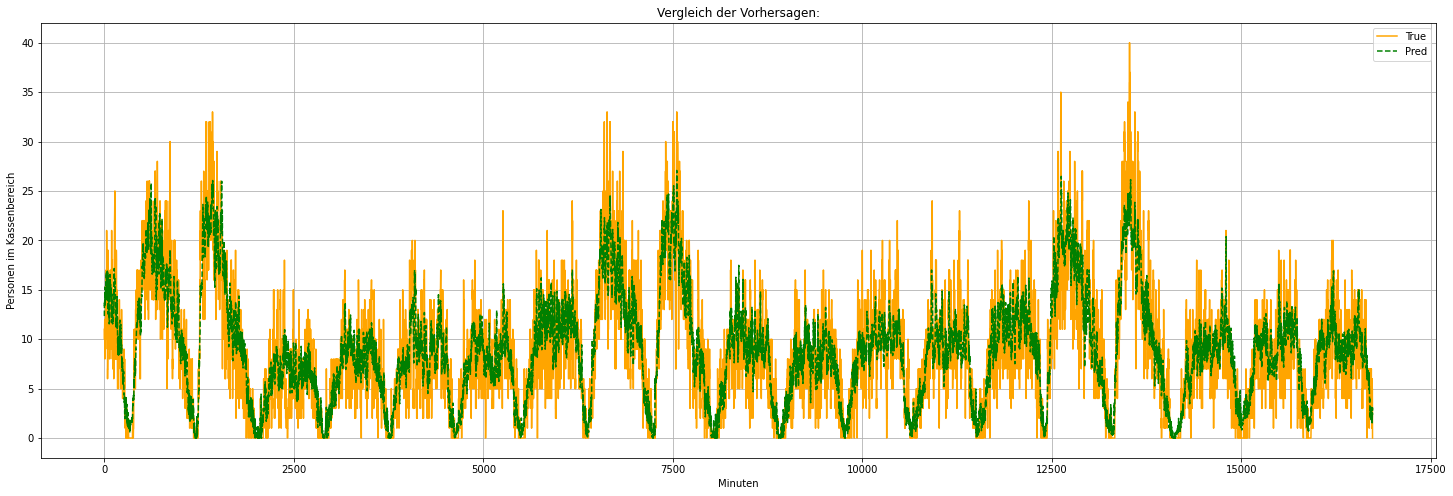

In [ ]:
plot_all_predictions(y_pred1, test_y)

### Tuning der Hyperparameter mit Hilfe eines Keras Tuners:

In [ ]:
def build_model(hp):
  # Sequential Model:
  model = Sequential()

  # Input Layer with Input-Shape:
  model.add(SimpleRNN(
    units=hp.Int('input_layer_units',  min_value=8, max_value=128, step=8), 
    input_shape=(N_INPUT, FEATURES), 
    return_sequences=True
  ))

  # Second RNN-Layer:
  model.add(SimpleRNN(
    units=hp.Int('layer_2_units', min_value=8, max_value=128, step=8)
  ))

  # Dropout-Layer:
  if hp.Boolean('dropout'):
    model.add(
      Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.0, step=0.1)
    ))
    
  # Dense Layer with units:
  model.add(Dense(
    units=hp.Int('units_dense', min_value=32, max_value=512, step=32)
  ))

  # Dense Layer with Output-Shape:
  model.add(Dense(
    units=M_OUTPUT
  ))

  # Configuration of optimizer and learnrate:
  model.compile(
    loss = 'mse', 
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),  
    metrics=['mae', 'mse'])  

  return model

#### RandomSearch

In [ ]:
ran_tuner = kt.RandomSearch(hypermodel=build_model, objective="val_loss", max_trials=10, seed=1111, project_name="ran_project")
ran_tuner.search_space_summary()

Search space summary
Default search space size: 5
input_layer_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
ran_tuner.search(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=64, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/tmp/new/tb_logs_ran")])

# Retrieve the best model.s
ran_model = ran_tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 26m 10s]
val_loss: 10.282316207885742

Best val_loss So Far: 10.20766830444336
Total elapsed time: 03h 06m 01s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
ran_parameters = ran_tuner.get_best_hyperparameters(num_trials=1)[0]

ran_parameters.values

{'dropout': True,
 'dropout_rate': 0.1,
 'input_layer_units': 120,
 'layer_2_units': 56,
 'learning_rate': 0.0001,
 'units_dense': 352}

In [ ]:
ran_model.save('/content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/models/new/ran_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/models/new/ran_model/assets


#### BayesianOptimazation:

In [ ]:
bay_tuner = kt.BayesianOptimization(build_model, max_trials=10, objective='val_loss', seed=1111, project_name="bay_project")
bay_tuner.search_space_summary()

Search space summary
Default search space size: 5
input_layer_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
bay_tuner.search(train_x, train_y, validation_data=(test_x, test_y), epochs=EPOCHS, batch_size=64, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/tmp/new/tb_logs_bay")])

# Retrieve the best model.s
bay_model = bay_tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 08m 38s]
val_loss: 21.403169631958008

Best val_loss So Far: 10.210714340209961
Total elapsed time: 03h 42m 48s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
bay_parameters = bay_tuner.get_best_hyperparameters(num_trials=1)[0]

bay_parameters.values

{'dropout': True,
 'dropout_rate': 0.30000000000000004,
 'input_layer_units': 104,
 'layer_2_units': 64,
 'learning_rate': 0.0001,
 'units_dense': 64}

In [ ]:
bay_model.save('/content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/models/new/bay_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/models/new/bay_model/assets


#### Hyperband:

In [ ]:
hyp_tuner = kt.Hyperband(hypermodel=build_model, objective='val_mse', max_epochs=20, seed=1113)
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 5
input_layer_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
units_dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
hyp_tuner.search(train_x, train_y, validation_data=(test_x, test_y), batch_size=64, callbacks=[early_stop, keras.callbacks.TensorBoard("/content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/tmp/new/tb_logs_hyp")])

# Retrieve the best model.s
hyp_model = hyp_tuner.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 22m 05s]
val_mse: 11.155879974365234

Best val_mse So Far: 10.062246322631836
Total elapsed time: 04h 10m 31s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get best parameters
hyp_parameters = hyp_tuner.get_best_hyperparameters(num_trials=1)[0]

hyp_parameters.values

{'dropout': True,
 'dropout_rate': 0.0,
 'input_layer_units': 40,
 'layer_2_units': 120,
 'learning_rate': 0.001,
 'tuner/bracket': 2,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/round': 2,
 'tuner/trial_id': '7fdcc4eb70b7b9bb0d8c9ad9fb01280e',
 'units_dense': 160}

In [ ]:
hyp_model.save('/content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/models/new/hyp_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sensalytics/Modelle/Vanilla-RNN/models/new/hyp_model/assets
